In [1]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.sparse import random, find
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import scipy
from scipy import sparse, linalg
from scipy.sparse import coo_matrix
import math

In [2]:
d = 50
k = 10
A = random(d, d, density=1.0)
# psd matrix
A = A.dot(A.T)

In [13]:
def pi(A, X, epochs=100):
    nnz = A.nnz
    k = X.shape[1]
    R = np.diag(np.array([1.0]*k))
    loss = []
    rows, cols, vals = find(A)
    A = A.toarray()
    for i in range(epochs):
        # Evaluate on full matrix
#         err = np.asarray(X.dot(R.dot(X.T)) - A)
#         mse = np.sum(err**2)/nnz/2
        
        # Evaluate on observed matrix
        err = [(np.sum(np.dot(X[rows[j]], np.dot(R, X[cols[j]].T))) - vals[j]) for j in range(nnz)]
        mse = sum([er*er for er in err])/nnz/2

        print (mse)
        loss.append(mse)
        X = A.dot(X)
        X, R = np.linalg.qr(X)
        R = np.diag(np.diag(X.T.dot(A).dot(X)))

    return X, loss

def gd(A, X, lr, epochs=100):
    d = A.shape[0]
    nnz = A.nnz
    k = X.shape[1]
    loss = []
    rows, cols, vals = find(A)
    for i in range(epochs):
        # Evaluate on full matrix
#         err = [np.asarray(X.dot(X.T) - A)]
#         mse = np.sum(err**2)/nnz/2

        # Evaluate on observed matrix
        err = [(np.sum(X[rows[j]]*X[cols[j]]) - vals[j]) for j in range(nnz)]
        mse = sum([er*er for er in err])/nnz/2
        print (mse)
        loss.append(mse)
#         grad = err.dot(X)/nnz
#         X -= lr * grad
        grad_rows = [e*X[j]/2/nnz for j, e in zip(rows, err)]
        grad_cols = [e*X[j]/2/nnz for j, e in zip(cols, err)]
#         grad_rows = [err*X[j]/2/nnz for j, err in zip(rows, err)]
#         grad_cols = [err*X[j]/2/nnz for j, err in zip(cols, err)]
        
        for j in range(nnz):
            X[rows[j]] -= lr * grad_cols[j]
            X[cols[j]] -= lr * grad_rows[j]
        
    return X, loss

def sgd(A, X, bz, lr, epochs=100):
    d = A.shape[0]
    nnz = A.nnz
    k = X.shape[1]
    loss = []
    rows, cols, vals = find(A)
    for i in range(epochs):
        # Evaluate on full matrix
#         err = np.asarray(X.dot(X.T) - A)
#         mse = np.sum(err**2)/nnz/2

        # Evaluate on observed matrix
        err = [(np.sum(X[rows[j]]*X[cols[j]]) - vals[j]) for j in range(nnz)]
        mse = sum([er*er for er in err])/nnz/2
        print (mse)
        loss.append(mse)
        
        perm_idx = np.random.permutation(nnz)
        for i in range(0,nnz, bz):
            idx_end = min(nnz, i + bz)
            bz_idx = perm_idx[i:idx_end]
            bz_size = idx_end - i
            batch_err = [(np.sum(X[rows[j]]*X[cols[j]]) - vals[j]) for j in bz_idx]
            batch_grad_row = [err*X[rows[j]]/2/bz_size for j, err in zip(bz_idx, batch_err)]
            batch_grad_col = [err*X[cols[j]]/2/bz_size for j, err in zip(bz_idx, batch_err)]
            for j, grad_row, grad_col in zip(bz_idx,batch_grad_row, batch_grad_col):
                X[cols[j]] -= lr * grad_row
                X[rows[j]] -= lr * grad_col
    return X, loss

def svrg(A, X, bz, lr, T, epochs=100):
    d = A.shape[0]
    nnz = A.nnz
    k = X.shape[1]
    loss = []
    rows, cols, vals = find(A)
    for i in range(epochs):
        # Evaluate on full matrix
#         err = np.asarray(X.dot(X.T) - A)
#         mse = np.sum(err**2)/nnz/2

        # Evaluate on observed matrix
        err = [(np.sum(X[rows[j]]*X[cols[j]]) - vals[j]) for j in range(nnz)]
        mse = sum([er*er for er in err])/nnz/2
        print (mse)
        loss.append(mse)
        if i % T == 0:
#             full_grad = err.dot(X)/nnz
            X_tilde = np.copy(X)
            grad_rows = [e*X[j]/2/nnz for j, e in zip(rows, err)]
            grad_cols = [e*X[j]/2/nnz for j, e in zip(cols, err)]
#             grad_rows = [err*X[j]/2/nnz for j, err in zip(rows, err)]
#             grad_cols = [err*X[j]/2/nnz for j, err in zip(cols, err)]
        
        perm_idx = np.random.permutation(nnz)
        for i in range(0,nnz, bz):
            idx_end = min(nnz, i + bz)
            bz_idx = perm_idx[i:idx_end]
            bz_size = idx_end - i
            batch_err = [(np.sum(X[rows[j]]*X[cols[j]]) - vals[j]) for j in bz_idx]
            batch_grad_row = [err*X[rows[j]]/2/bz_size for j, err in zip(bz_idx, batch_err)]
            batch_grad_col = [err*X[cols[j]]/2/bz_size for j, err in zip(bz_idx, batch_err)]
            
            batch_err_tilde = [(np.sum(X_tilde[rows[j]]*X_tilde[cols[j]]) - vals[j]) for j in bz_idx]
            batch_grad_row_tilde = [err*X_tilde[rows[j]]/2/bz_size for j, err in zip(bz_idx, batch_err_tilde)]
            batch_grad_col_tilde = [err*X_tilde[cols[j]]/2/bz_size for j, err in zip(bz_idx, batch_err_tilde)]
            
            for j, grad_row, grad_col,grad_row_tilde, grad_col_tilde in zip(bz_idx,batch_grad_row, batch_grad_col, batch_grad_row_tilde, batch_grad_col_tilde):
                X[cols[j]] -= lr * (grad_row - grad_row_tilde)
                X[rows[j]] -= lr * (grad_col - grad_col_tilde)
                
            for j in range(nnz):
                X[rows[j]] -= lr * grad_cols[j]
                X[cols[j]] -= lr * grad_rows[j]
    return X, loss

In [4]:
np.random.seed(1)
X0 = np.random.randn(d,k)
lr = 0.5
epochs = 100
X, loss_gd = gd(A, np.copy(X0), lr, epochs)

78.42458517090783
77.7638890467871
77.03009777930866
76.19984072313052
75.24613736165631
74.13793913786661
72.83985674394688
71.31221695146957
69.51165349778069
67.39250083275992
64.90931067901774
62.020816601571454
58.69557853883035
54.91927850217867
50.703145962403475
46.09225696387419
41.17159939134682
36.06716453588586
30.93944929884942
25.9681565335703
21.32962410842548
17.171753428121992
13.593268508410585
10.63343712863199
8.274772592897468
6.4564757226594764
5.093044459069752
4.092070130540953
3.367279072207101
2.8456793133032936
2.4697525111341756
2.1964774975606027
1.9948666587718105
1.8431724672472067
1.7263782955018048
1.6341989704932733
1.5595995395730515
1.4977483845180866
1.4452994458488129
1.3999091026244896
1.35991405956579
1.3241171009212898
1.2916441358391515
1.261848091839177
1.2342436063016764
1.208462072336491
1.1842202602521625
1.1612981022676865
1.139522748030956
1.118756974940154
1.0988906675269041
1.0798344904431456
1.0615151497624065
1.0438718176711252
1.0268

In [5]:
lr = 0.5
bz = 100
X, loss_sgd = sgd(A, np.copy(X0), bz, lr, epochs)

78.42458517090783
5.284113381126493
1.0231258811157813
0.719865478114286
0.5659407507176201
0.4718353385003692
0.41513935677712943
0.37200759230143116
0.34262062949948663
0.3215673738936495
0.30477377286523194
0.29220355088294686
0.27840063751467464
0.2698892420209069
0.264451566553546
0.25434172138549127
0.24942521925052946
0.24238288113827636
0.2380639843702147
0.2343866455878327
0.22723822570673702
0.22284088178522724
0.21806550555250223
0.21456860467077063
0.21301911655117664
0.20899442138875673
0.20564458237604535
0.2005804762976286
0.19786528303082862
0.19312747671689703
0.18956088467003862
0.18747660103612848
0.18441042687518985
0.18173595065748208
0.1799399588672398
0.17635017259358973
0.17290163854121002
0.16889808607167334
0.16777281755381562
0.16718661683293456
0.16246942756108365
0.1604475662604524
0.15776069881075647
0.1550711661458586
0.15321784903002642
0.1511338025457851
0.14863323314818835
0.14799083886577297
0.145632636015725
0.14383846762580252
0.1418609663943508
0.1

In [6]:
T = 1
lr = 0.5
X, loss_svrg = svrg(A, np.copy(X0), bz, lr, T, epochs)

78.42458517090783
6.953210387369781
1.2331429689959226
0.8042135223100565
0.6155542667782296
0.5045927894542352
0.4345243345098058
0.3869365733364261
0.35303937040105965
0.3278781125329339
0.30856260209872177
0.29327431490534905
0.28086642286426927
0.27053477118744235
0.26174924667839294
0.25414462707631735
0.24740447962884732
0.24136993519909292
0.2358795539561875
0.2308161660835711
0.2261053150218991
0.22167361307996408
0.217470716240829
0.21346333024949077
0.209616840552192
0.20591509842135852
0.20232978997338863
0.19884544075908295
0.19545104021490334
0.19214501190578961
0.18892507822400742
0.18577519125024078
0.18270106367710823
0.17970044703819812
0.17676926236145032
0.1739085958754422
0.1711192169275254
0.16839873680168907
0.16574954003289005
0.16316751073708488
0.16066199075769347
0.15822651052750658
0.15586563332983588
0.15357670996275102
0.1513632081287709
0.14922339475306393
0.14715480010091736
0.14515787497594654
0.14323363629862512
0.14138048185796173
0.13959735298254305
0

In [14]:
X, loss_pi = pi(A, np.copy(X0), epochs)

78.42458517090783
31.513816839502176
0.36818091879143183
0.11560384392451181
0.10564490260395491
0.10072980897540457
0.09812819799317549
0.09668101684155525
0.09584450347046196
0.0953406482099941
0.09501985644745639
0.09479954956098913
0.09463346220734796
0.09449567702857052
0.09437206350129833
0.09425538112996805
0.09414225292739689
0.09403123920658181
0.09392167965062581
0.09381309903240723
0.09370499339882081
0.0935968326755556
0.09348815486038307
0.09337867311974853
0.09326835542999597
0.09315746166389395
0.09304653719035094
0.09293636931980322
0.0928279166294243
0.09272222302061826
0.09262032873540928
0.0925231894427082
0.09243161196598353
0.09234621169052278
0.09226739288234485
0.09219534983185476
0.09213008444860342
0.09207143487761878
0.09201910975582629
0.09197272354870657
0.09193182961612241
0.09189594892195842
0.09186459340524122
0.09183728386561855
0.09181356276682098
0.09179300266516875
0.09177521108627505
0.09175983266384355
0.09174654927241857
0.09173507877025971
0.09172

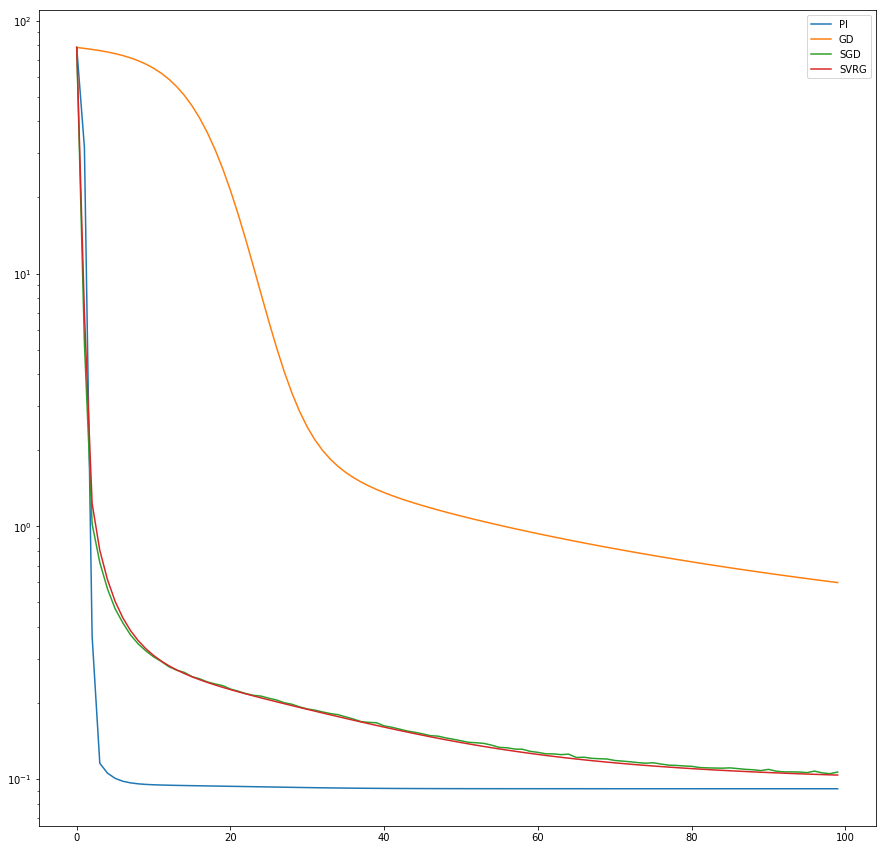

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
plt.semilogy(np.array(loss_pi), label="PI")
plt.semilogy(np.array(loss_gd), label="GD")
plt.semilogy(np.array(loss_sgd), label="SGD")
plt.semilogy(np.array(loss_svrg), label="SVRG")
plt.legend(loc='best')